# Assignment 1: Deadline: first class in week 4 of the course: 25-2-2025 10:00 (if updated).
Hand in this notebook with output. Make sure that it is able to run and produce all the figures and results you show. Also, use the text boxes to answer the questions and interpret your results, relating them to the course materials.


Exercises made by Oliver Gurney-Champion. Please contact us via Canvas, or e-mail directly to:
Oliver: o.j.gurney-champion@amsterdamumc.nl
Matthan: m.w.a.caan@amsterdamumc.nl
Dilara: d.tank@amsterdamumc.nl
Daan: d.kuppens@amsterdamumc.nl

These are a large set of challenging exercises, for which you will get 3 weeks to complete. I would strongly advise you to stick to the suggested schedule, which will ensure you have sufficient knowledge to answer the questions when completing them, and finalize all questions in time.

Note that the networks will be lite and can run on your local computer/laptop in short time (minutes). There is no need as yet to run this on Surf, although we highly encourage you to make sure Surf works for you (for exercise sets 2 and 3).

# Exercise 1: Program network in PyTorch. (60%)
During the class, a brief introduction was given to quantitative imaging. In this exercise, you will program your first neural network that will help estimate quantitative MRI parameters from quantitative data. In particular, we will be looking at the intra-voxel incoherent motion (IVIM) model for diffusion-weighted MRI:

S(b)=S_0×( (1-f)×e^-b×D^ +f×e^-b×D*^ )                                                                    [1]

With S the measured signal, S0 the baseline signal at S(b=0), f the perfusion fraction, D the diffusion coefficient and D* the pseudo diffusion coefficient. For more information on what the model means exactly and how it is used clinically, I would suggest reading "Introduction to IVIM MRI | Radiology Key" (https://radiologykey.com/introduction-to-ivim-mri/). But for the purpose of this exercise, it is just a model.

Normally, f, D and D* (named Dp in the code) are obtained by fitting S(b) using least-squares fitting. But these approaches are known to be prone to noise in the data and often produce poor estimates.

Therefore, you will write a neural network that predicts f from a given S(b). There are great tools available that take care of training models, such as PyTorch, Karas and Tensorflow. However, for the purpose of this exercise, you will make use of PyTorch. Moreover, we will use weights-and-biasses to keep track of how training is going.

# Wednesday 3-4-2024
At https://github.com/oliverchampion/AI_for_medical_imaging_course you will find the Python assignment. To help visualize progress and to isolate certain snippets of code, we wrote this as a Jupyter Notebook (exercise1.ipynb). As you can see, we have already provided a data-generator, some plotting tools to plot the training progress. The notebook should run as is and train a neural network! For your first lecture, we suggest you (Wednesday)
-	Install all prerequisites in your virtual enviroment (requierements.txt)
-	Start a WandB account @ https://wandb.ai/  you will need to log in when running the script
-	Go through the script to see whether you understand what happens.
-	Train your first neural network .
-	Visualize the results on your WandB page.

## Import requiered packages
imports the packages and sets the random seed

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import random
import numpy as np
import helper_functions as hf
import torch
import os
import torch.nn as nn
from matplotlib import pyplot as plt

# set random seed
seed =42

login to your free wandb account. Note you will need to set up your account on https://wandb.ai/authorize
wandb allows you to keep track of your neural network training.

In [2]:
import wandb
os.environ["WANDB_SILENT"] = "true"
%env WANDB_SILENT=True
wandb.login()

env: WANDB_SILENT=True


True

## Simulate and view the IVIM data
This allows you to study what the data looks like in jupyter.

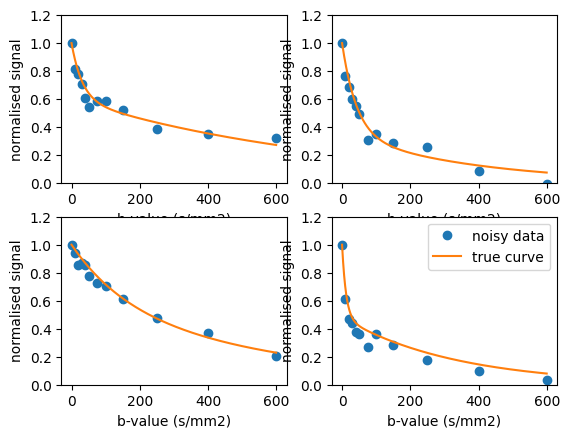

In [3]:
# set b-values at which we "measure" (i.e. simulate signal)
bvalues=[0, 10, 20, 30, 40, 50, 75, 100, 150, 250, 400, 600]

## Set the random seeds for reproducibility
np.random.seed(seed)
random.seed(seed)

## Loading the (simulated) dataset
data_sim, D, f, Dp = hf.sim_signal(SNR=(10,30),bvalues=bvalues,sims=30,seed=np.random.randint(1,10000))

## plotting some curves and data for visualisation
fig, axs = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        axs[i, j].plot(bvalues, data_sim[i+10*j,:], 'o')
        datapred=hf.ivim(np.arange(0,np.max(bvalues)), D[i+10*j], f[i+10*j], Dp[i+10*j], 1)
        axs[i, j].plot(np.arange(0,np.max(bvalues)), datapred)
        axs[i, j].set_ylim(0, 1.2)
        axs[i, j].set(xlabel='b-value (s/mm2)', ylabel='normalised signal')
plt.legend(('noisy data', 'true curve'))

## Splitting the data into training and validation
Here, we split our data into a training set, validation set and test set. Note that the current implementation only uses the training set and it is up to you (in your exercises) to also implement the validation and test run. At this point, we already split the data for you.

In [4]:
def sim_dat(bvalues,batch_size = 16,SNR=(10,40),sims=1000,seed=np.random.randint(1,10000)):
    with wandb.init(project="AI_for_medical_imaging", job_type="visualize data") as run:
        data_sim = hf.sim_signal(SNR=SNR,bvalues=bvalues,sims=sims,seed=seed)
        # Only for visualisation purposes: here we create our "Artifact" in wandb --> this allows viewing the data in your wandb account
        for i in range(4):
            #make b-value data pairs
            example_data=[[x,y] for (x,y) in zip(bvalues,data_sim[0][i])]
            # put it in a table
            table = wandb.Table(data=example_data, columns=["b-values", "signal"])
            #tell wandb to plot the table
            wandb.log({"data_plot " + str(i): wandb.plot.scatter(table, "b-values", "signal")})

        # here we split the data into train (70%), test (15%) and validation (15%) sets
        #split = int(np.floor(len(data_sim[0]) * 0.7))
        train_set, test_set, val_set = torch.utils.data.random_split([[data_sim[0][i,:],data_sim[1][i],data_sim[2][i],data_sim[3][i]] for i in range(len(data_sim[3]))],[0.7,0.15,0.15])
        #split = int(np.floor(len(rest) * 0.5))
        #test_set, val_set = torch.utils.data.random_split([[rest[0][i,:],rest[1][i],rest[2][i],rest[3][i]] for i in range(len(rest[3]))],[split, len(rest[0]) - split])

        # train loader loads the trianing data. We want to shuffle to make sure data order is modified each epoch and different data is selected each epoch.
        trainloader = torch.utils.data.DataLoader(train_set,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       drop_last=True)
        # validation data is loaded here. By not shuffling, we make sure the same data is loaded for validation every time. We can use substantially more data per batch as we are not training.
        inferloader = torch.utils.data.DataLoader(val_set,
                                       batch_size=min(batch_size,len(val_set)),
                                       shuffle=False,
                                       drop_last=False)
            # validation data is loaded here. By not shuffling, we make sure the same data is loaded for validation every time. We can use substantially more data per batch as we are not training.
        testloader = torch.utils.data.DataLoader(test_set,
                                       batch_size=min(batch_size,len(test_set)),
                                       shuffle=False,
                                       drop_last=False)
    return trainloader, inferloader, testloader
sim_dat(bvalues)

(<torch.utils.data.dataloader.DataLoader at 0x1c9aadb6690>,
 <torch.utils.data.dataloader.DataLoader at 0x1c9aad72890>)

## Design a neural network

In [5]:
# funtion for stacking the layers and making the model
def make_model(n_inputs=5,n_hidden=1,n_outputs=1):
    #initialize the model object
    model = nn.Sequential()
    # fill out the model with hidden layers.
    for i in range(n_hidden):
        # as we loop, we add hidden layers
        model.add_module('layer_linear'+str(i), nn.Linear(n_inputs, n_inputs))
        # we also add a ReLu layer
        model.add_module('layer_ReLu'+str(i), nn.ReLU())
    #and a final output layer
    model.add_module('last_layer',nn.Linear(n_inputs, n_outputs))
    # to ensure positive predictions, we end with a ReLu function before giving output
    model.add_module('last',nn.Sigmoid())
    model.apply(init_weights)
    return model

# function for initializing network weights for individual layers
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)

train your first network

In [22]:
def train_network(name, epochs=200, learningrate=0.1, hidden_layers=2, seed=42, optimizer='SGD',bvalues=bvalues,batch_size=16,sims=1000):

    trainloader, inferloader, testloader = sim_dat(bvalues,batch_size=batch_size,sims=sims)

    model = make_model(n_inputs=len(bvalues), n_hidden=hidden_layers, n_outputs=1)

    # initialize model --> we did this above, but during the exercise, you might be re-running this part of the script several times with different settings. This way we make sure you re-initiate the training and don't continue in the last model
    model.apply(init_weights)

    # initialize wandb
    wandb.init(
            project="AI_for_medical_imaging", job_type="training", name=name)

    # set random seed for reproducibility
    torch.manual_seed(seed)

    # probe available devices
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.determinstic = True
        torch.backends.cudnn.benchmark = False

    # Set default device. If GPU is available, the network will be trained on the GPU. Note that further down in the code, stuff will be sent ".to(device)" to make sure it is available on the GPU.
    device = torch.device('cpu')#'cuda' if torch.cuda.is_available() else 'cpu')

    # define the loss of the network (mean square error)
    loss_module = nn.MSELoss(reduction='mean').to(device)

    # the optimizer determines how strongly to update the network's weights based on the calculated loss.
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learningrate)
    elif optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learningrate)
    else:
        raise NotImplementedError('this optimizer is not implemented yet...')


    plot_data = {
        "train_loss": [],
        "val_loss": [],
        "SD_train": [],
        "SD_val": [],
        "sys_train": [],
        "sys_val": []
    }

    # loop over epochs
    for epoch in range(epochs):
        # initiate losses to 0
        train_loss_f = 0
        val_loss_f = 0
        # set model to training such that forward passes are remembered (requiered for backpropogating the loss)
        model.train()
        #loop over all training data0
        SD_train = 0
        sys_train = 0
        for x in trainloader:
            # reset the gradients to zero
            optimizer.zero_grad()
            # get data (x[0]) and put the data on the GPU if available
            batch=x[0].to(device)
            # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
            f_ref = torch.flatten(x[2].to(device))
            # put the data through the neural network
            f_pred = torch.flatten(model.forward(batch))
            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_ref)
            #add found loss to the train loss, to keep track of the loss this epoch
            train_loss_f += loss_f.item()
            # propogate the loss through the network (calculate d_wights/d_loss)
            loss_f.backward()
            # update all weights accoording to their derrivatives to the loss.
            optimizer.step()
            # calculate the standard deviation and systematic error on the trianing data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_ref.cpu().detach().numpy())
            # add the errors to ultimately calculate their mean over the training data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_train += SD**2
            sys_train += sys
        # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
        SD_train = np.sqrt(SD_train/trainloader.__len__())
        sys_train = sys_train/trainloader.__len__()
        # after training, set model to evaluation mode
        model.eval()
        # initialize error_metrics
        SD_val=0
        sys_val=0
        ######################your code here for validation loss#########################

        for x in inferloader:
            # get data (x[0]) and put the data on the GPU if available
            batch=x[0].to(device)
            # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
            f_ref = torch.flatten(x[2].to(device))
            # put the data through the neural network
            f_pred = torch.flatten(model.forward(batch))
            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_ref)
            #add found loss to the validation loss, to keep track of the loss this epoch
            val_loss_f += loss_f.item()
            # calculate the standard deviation and systematic error on the validation data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_ref.cpu().detach().numpy())
            # add the errors to ultimately calculate their mean over the validation data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_val += SD**2
            sys_val += sys

        # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
        SD_val = np.sqrt(SD_val/inferloader.__len__())
        sys_val = sys_val/inferloader.__len__()
            
        
        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
        example_data=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
        # put it in a table
        table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])
        #tell wandb to plot the table
        # note that some parameters are being logged which you still need to define in the validation loop!
        #if epoch % 10 == 0:
        # wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_train,"error/systematic error":sys_train,"data_plot epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'epoch{epoch}')})

        plot_data["train_loss"].append(train_loss_f/trainloader.__len__())
        plot_data["val_loss"].append(val_loss_f/inferloader.__len__())
        plot_data["SD_train"].append(SD_train)
        plot_data["SD_val"].append(SD_val)  
        plot_data["sys_train"].append(sys_train)
        plot_data["sys_val"].append(sys_val)

        ## print output in terminal. Only useful for debugging when WandB does not work
        #print('epoch = ' + str(epoch) + ' train loss =' + str(train_loss_f/trainloader.__len__()) +' val loss =' + str(val_loss_f/inferloader.__len__()) + 'the systematic error is ' + str(sys_val) + ' and the random error is ' + str(SD_val))

    wandb.finish()

    # initialize error_metrics
    SD_test=0
    sys_test=0
    test_loss_f=0
    ######################your code here for testing loss#########################

    for x in testloader:
        # get data (x[0]) and put the data on the GPU if available
        batch=x[0].to(device)
        # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
        f_ref = torch.flatten(x[2].to(device))
        # put the data through the neural network
        f_pred = torch.flatten(model.forward(batch))
        # calculate loss (compare predicted f to the ground trueth)
        loss_f = loss_module(f_pred, f_ref)
        #add found loss to the validation loss, to keep track of the loss this epoch
        test_loss_f += loss_f.item()
        # calculate the standard deviation and systematic error on the validation data
        SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_ref.cpu().detach().numpy())
        # add the errors to ultimately calculate their mean over the validation data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
        SD_test += SD**2
        sys_test += sys

    # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
    SD_test = np.sqrt(SD_test/testloader.__len__())
    sys_test = sys_test/testloader.__len__()
    test_loss = test_loss_f/testloader.__len__()
    
    #return val_test SD_test
    return plot_data, SD_test, sys_test, test_loss

plot_data_SGD, SD_test_SGD, sys_test_SGD, test_loss_SGD = train_network('test_SGD', optimizer='SGD')
plot_data_ADAM, SD_test_ADAM, sys_test_ADAM, test_loss_ADAM = train_network('test_ADAM', optimizer='adam')

C:\Users\jonas\AppData\Local\Temp\ipykernel_32224\2069698230.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


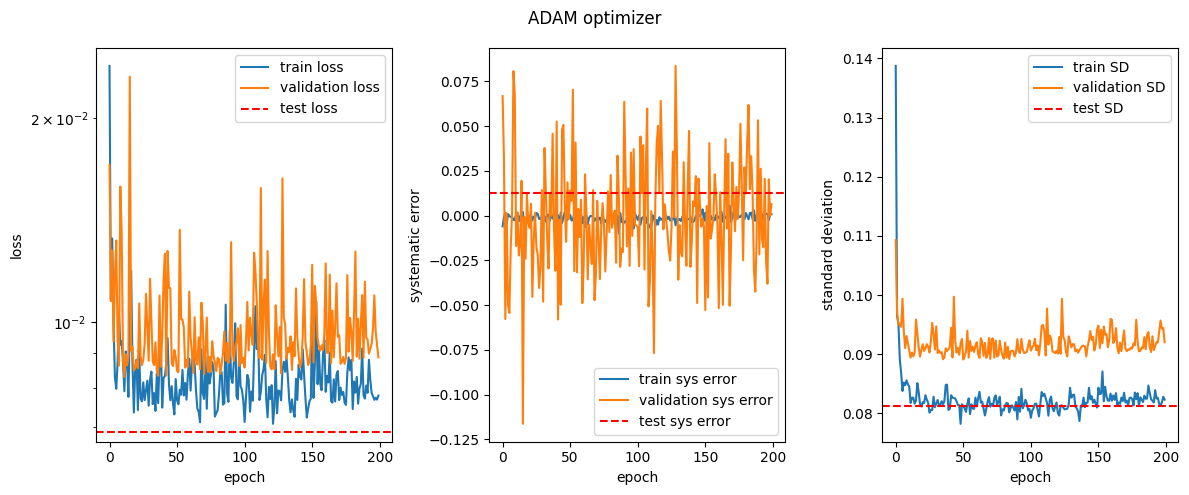

In [38]:
fig,axs = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle('ADAM optimizer')

axs[0].semilogy(plot_data_ADAM['train_loss'])
axs[0].semilogy(plot_data_ADAM['val_loss'])
axs[0].axhline(y=test_loss_ADAM, color='r', linestyle='--')
axs[0].legend(['train loss', 'validation loss', 'test loss'])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')


axs[1].plot(plot_data_ADAM['sys_train'])
axs[1].plot(plot_data_ADAM['sys_val'])
axs[1].axhline(y=sys_test_ADAM, color='r', linestyle='--')
axs[1].legend(['train sys error', 'validation sys error', 'test sys error'])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('systematic error')


axs[2].plot(plot_data_ADAM['SD_train'])
axs[2].plot(plot_data_ADAM['SD_val'])
axs[2].axhline(y=SD_test_ADAM, color='r', linestyle='--')
axs[2].legend(['train SD', 'validation SD', 'test SD'])
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('standard deviation')

fig.tight_layout()
fig.show()

C:\Users\jonas\AppData\Local\Temp\ipykernel_32224\2710263388.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


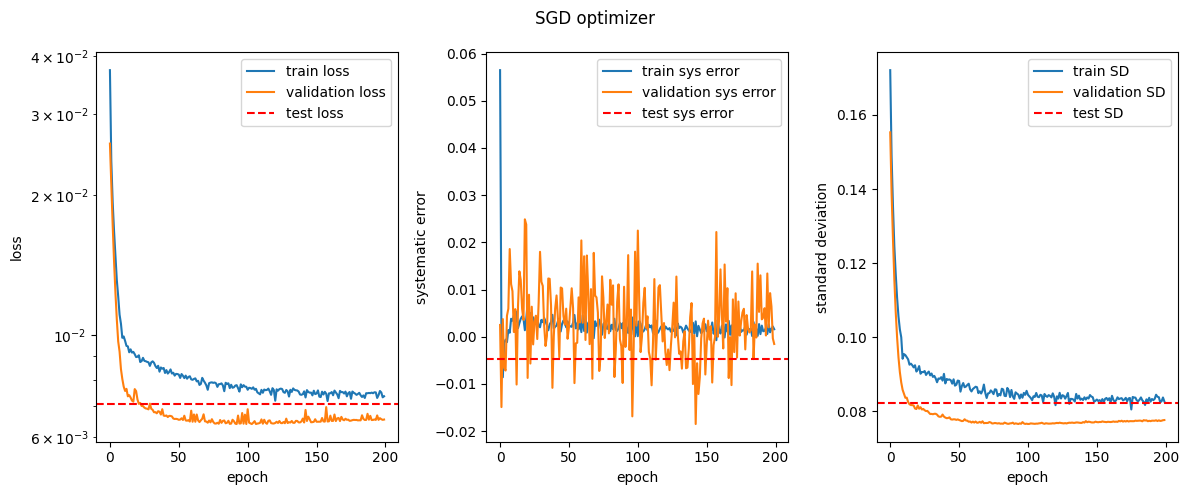

In [40]:
fig,axs = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle('SGD optimizer')

axs[0].semilogy(plot_data_SGD['train_loss'])
axs[0].semilogy(plot_data_SGD['val_loss'])
axs[0].axhline(y=test_loss_SGD, color='r', linestyle='--')
axs[0].legend(['train loss', 'validation loss', 'test loss'])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')


axs[1].plot(plot_data_SGD['sys_train'])
axs[1].plot(plot_data_SGD['sys_val'])
axs[1].axhline(y=sys_test_SGD, color='r', linestyle='--')
axs[1].legend(['train sys error', 'validation sys error', 'test sys error'])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('systematic error')


axs[2].plot(plot_data_SGD['SD_train'])
axs[2].plot(plot_data_SGD['SD_val'])
axs[2].axhline(y=SD_test_SGD, color='r', linestyle='--')
axs[2].legend(['train SD', 'validation SD', 'test SD'])
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('standard deviation')

fig.tight_layout()
fig.show()

C:\Users\jonas\AppData\Local\Temp\ipykernel_32224\3917349644.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


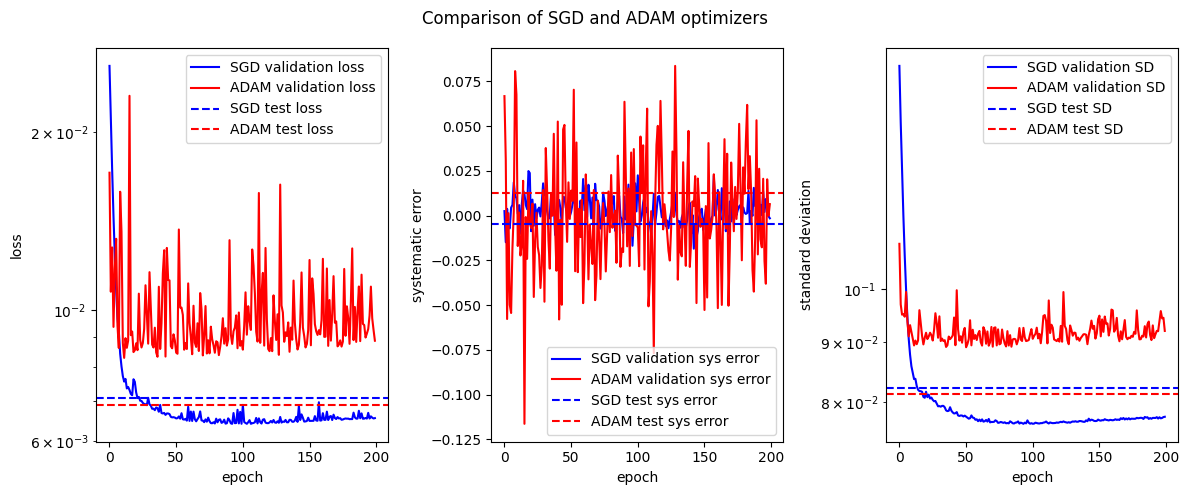

In [39]:
fig,axs = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle('Comparison of SGD and ADAM optimizers')

axs[0].semilogy(plot_data_SGD['val_loss'], color='b')
axs[0].semilogy(plot_data_ADAM['val_loss'], color='r')
axs[0].axhline(y=test_loss_SGD, color='b', linestyle='--')
axs[0].axhline(y=test_loss_ADAM, color='r', linestyle='--')
axs[0].legend(['SGD validation loss', 'ADAM validation loss', 'SGD test loss', 'ADAM test loss'])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')


axs[1].plot(plot_data_SGD['sys_val'], color='b')
axs[1].plot(plot_data_ADAM['sys_val'], color='r')
axs[1].axhline(y=sys_test_SGD, color='b', linestyle='--')
axs[1].axhline(y=sys_test_ADAM, color='r', linestyle='--')
axs[1].legend(['SGD validation sys error', 'ADAM validation sys error', 'SGD test sys error','ADAM test sys error'])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('systematic error')


axs[2].semilogy(plot_data_SGD['SD_val'], color='b')
axs[2].semilogy(plot_data_ADAM['SD_val'], color='r')
axs[2].axhline(y=SD_test_SGD, color='b', linestyle='--')
axs[2].axhline(y=SD_test_ADAM, color='r', linestyle='--')
axs[2].legend(['SGD validation SD', 'ADAM validation SD', 'SGD test SD', 'ADAM test SD'])
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('standard deviation')

fig.tight_layout()
fig.show()

/var/folders/zd/05ndgbcd4k35_hn1kps4c8sr0000gn/T/ipykernel_57260/3505502154.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


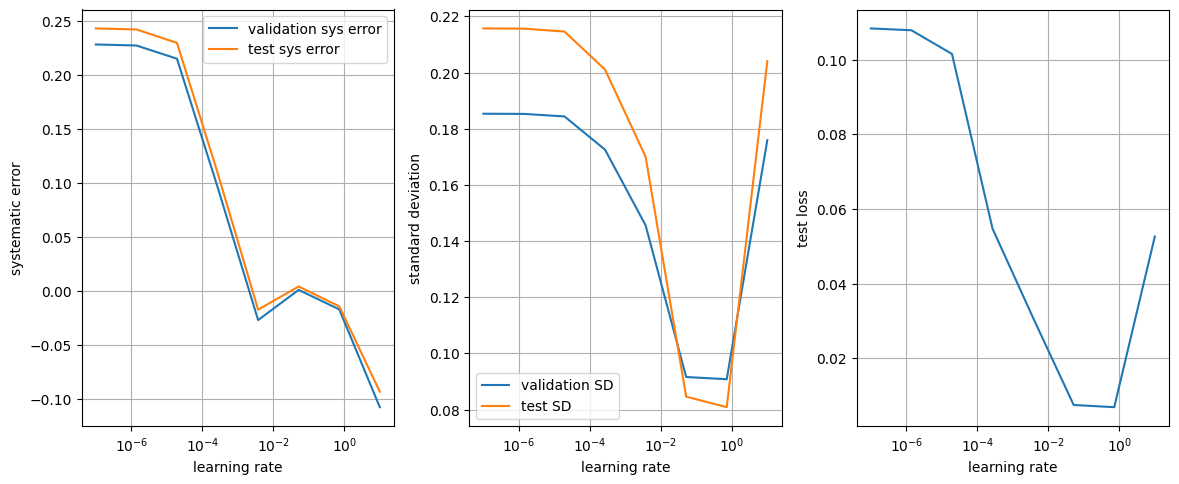

In [11]:
# train the network using the SGD optimizer for different learning rates

leanring_rate = np.logspace(-7, 1, 8)

sys_val_list = []
sys_test_list = []
SD_val_list = []
SD_test_list = []
lest_loss_list = []

for rates in leanring_rate:
    plot_data, SD_test, sys_test, test_loss = train_network('test_SGD', optimizer='SGD', learningrate=rates)
    
    sys_val_list.append(plot_data['sys_val'][-1])
    sys_test_list.append(sys_test)
    SD_val_list.append(plot_data['SD_val'][-1])
    SD_test_list.append(SD_test)
    lest_loss_list.append(test_loss)
    
fig,axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].plot(leanring_rate, sys_val_list)
axs[0].plot(leanring_rate, sys_test_list)
axs[0].legend(['validation sys error', 'test sys error'])
axs[0].set_xlabel('learning rate')
axs[0].set_ylabel('systematic error')
axs[0].set_xscale('log')
axs[0].grid(True)

axs[1].plot(leanring_rate, SD_val_list)
axs[1].plot(leanring_rate, SD_test_list)
axs[1].legend(['validation SD', 'test SD'])
axs[1].set_xlabel('learning rate')
axs[1].set_ylabel('standard deviation')
axs[1].set_xscale('log')
axs[1].grid(True)

fig.tight_layout()
fig.show()

# Extra plot for test loss
plt.plot(leanring_rate, lest_loss_list)
plt.xlabel('learning rate')
plt.ylabel('test loss')
plt.xscale('log')
plt.grid(True)
plt.show()

# First week (on schedule means finish by Friday) [if updated: 7-2-2025]
For these exercises, you will want to produce new cells that generate the outputs. The notebook cells should run and produce the figures without input of the examiners.

## 1A-C: train the neural network
Adapt the script above for your exercises A-C such that it produces the desired results and plots. Describe the results/intepertation in this text baloon.

A.	The current network implementation only looks at training data. This means that the network’s performance is over-estimated. Please use the validation set to monitor performance during training (note that we have already put the model on evaluation mode in line 59). At what point is the network fully trained? Explain how you know this. Show the effect from overfitting and underfitting.

The model is fully trained only at the very end of the epochs loop, so once the function has finished running. This is because the model changes the weights (optimiser.step()) for every iteration in the epochs loop (only in the training loop).

At first the model underfits, here the training loss is higher than the validation loss and the slope of the validation loss curve is negative. Overfitting does not occur in this example. The validation curve stays flat for after 175 epochs and does not start to rise again (yet).


B.	Similarly, use the test dataset to test for final performance. Explain why this is needed.

Once the model is fully trained we need to test the performance on a dataset that is new to the model. Otherwise the fact that the model was trained on the data would bias the performance.

C.	Currently, standard gradient descent optimizer is being used to train the network, with a learning rate of 0.01. Investigate the performance of the network for different optimizer (i.e. adam loss was discussed in the lecture) and explain what you see. What does the Adam optimizer do differently from the SGD optimizer that would make it perform better/differently?



D.	Return back to SGD. Test how the performance depends on the learning rate. This can be done by plotting the systematic (sys_test) and random (SD_test) errors as function of learning rate (10<LR<0.0000001; steps in order of magnitude; e.g. 10, 1, 0.1, ….).
##### Plot the performance (sys_val and SD_val) as function of the learning rate and add this to your report. Explain what you see (hint: take a look at the loss curves).
easiest is to save the final performance and plot it in the jupyter notebook.

E.	Plot the performance (sys_val and SD_val) as function of the width (number of neurons per layer: 5, 10, 20, 50, 100) and depth (number of hidden layers: 1, 2, ..., 8) of the network and add these to the report. Discuss how width and depth may influence the network; if it has this behaviour in your data, highlight it; if not, explain why it may not occur in your dataset.

Hint: currently, the width of the network copies the width of the data, so you need to uncouple the input width from the network width by adapting the "make model" code.
Tip: you only need to plot different widths for 1 depth (e.g. 2) and different depths for 1 width (e.g. 10).
Tip: possibly some effects get clearer when more training data is simulated ("sims" in data_sim). But also note that having too much training data may hide some of the effects from other exercises, so don't forget to revert it.

F.	Try different batch sizes (1, 4, 16, 64, 128, 516).Explain the behavior of the network you see.What is the effect of having smaller batches? And larger batches?

G.Chose 3 hidden layers, width of 40,  learning rate of 0.1 and batch size of 2. Now train the network for 3000 epochs. At what point in the network fully trained? How do you see this? Does any overfitting occur?

# Second week (on schedule means finish by Wednesday) [if updated: 12-2-2025]
H.	Currently, the model uses a Relu activation function. Test the effect of different activation funtions on the network performance. Show how well does a sigmoid or ELU work (i.e. what is the effect on performance)?

Note, you can either:
- adapt the scripts above to program this "neatly" as input parameter.
- redefine new "programs" below that have the new properties you want.

Note that in the case of option 1, your programs need to stay backwards compatible, as examiners will need to be able to rerun your code and reproduce your results!

So far, we simualted a small amount of data, as it is easier to show overfitting etc. Note that you may want to simulate somewhat more data for this and the following exercises. This can be achieved by setting sims=100000 for the following exercises

I.	Let the network also predict D and Dp (note x[1] and x[3] are D and Dp respectively). Show the loss curve of D and Dp and explain how you can see that they have been implemented properly/the model is learning them.
o	The network will need more than 1 output --> tip, use loss_D.backward(retain_graph=True) for the first two losses to remember losses and propogate all 3 losses backward in turn
o	Alternatively, you could train 3 networks simultaniously
Note that 0<f<1 on avergae is orders of magnitude larger than D and Dp. To ensure all three losses equally affect the network weights you may want to enlarge the loss of D and Dp by multiplying them with some value.


J.	Use the sigmoid in the final layer to constrain 0.5e-3 <D< 3.5e-3; 0<f<1; 5e-3<D*<130e-3. Explain how you did this.
Note: D, f and D* are in very different parameter value ranges, and hence their RMS is too. A network will focus on the largest loss. You may want to scale the RMS to similar ranges for the network to consider all 3 parameters during optmizing.
Also note: You may want to play with hyperparameters.

# For scoring 7.5+
So far, you have been working with simulated data (taken care of by Data_loader.py). For such data, we know the ground truth values. However, in vivo, we have no way of knowing the ground truth. How will our network perform? Note that for this exercise you may need ot play with hyperparameters and design choices to train.

K.	Use the network, as trained in (J) and apply it to real-world data which is provided by running “dataval, valid_id, bvalues = hf.load_real_data(eval=True)”.
- You will need to export you trained network in the return of the "train_network" function
- you will need to apply it to the "dataval" from hf.load_real_data(eval=True)
- you will then want to put the outputs through "hf.plot_example(np.squeeze(D_out), valid_id,0.003)", "hf.plot_example(np.squeeze(f_out), valid_id,0.7)" and "hf.plot_example(np.squeeze(Dp_out), valid_id,0.1)", with the predicted D, f and Dp being D_out, f_out and Dp_out.

Note that alongside your plot (the first), also a conventional least squares fit is provided as a reference. Show the resulting parameter maps. How does your approach compare? Why do you think your particular approach would look better/worse?

L.	Ideally, you would train your network on real-world data. However, in this particular case, it is hard to get gold standard references. Luckily, we can use our understanding of physics, and of how stuff “should behave” to work our way around this. You will redesign your network loss, such that it can train on data without any gold standard references! Instead of placing the L2 loss on f_pred v.s. f_ref. Currently, the network is learning to minimize the difference between predicted fpred and the ground truth referene ftrue. In vivo, we may not have these references. To overcome this, we will now introduce a physics-informed loss. Use the IVIM equation [1] to propogate the predictions (D, f and Dp) into the signal space (S). Then, take e.g. the mean-square-error between the predicted signal and the input signal. Note that you will need to use torch functions (instead of numpy functions) to ensure you can backpropogate the loss through the equation into the network. You can train this network on the simulated data from earlier exercises. But it should also be able to train it on the in vivo data from "datatrain, bvalues = hf.load_real_data(eval=False)". This ensures that the network is use to looking at "real" data. Optimize the network’s training using the real data provided (“test_in_vivo.py”; datatrain). Evaluate the network on the same data as in 1 (data, valid_id, bvalues = dl.load_real_data(eval=True)). How does it perform?


In [13]:
datatrain, bvalues = hf.load_real_data(eval=False)
dataval, valid_id, bvalues = hf.load_real_data(eval=True)
print('training data is ' + str(len(datatrain)) + ' long')

''''your code here'''
### use datatrain to train your network.
## then test your network using dataval.
''''if you manage to make predictions of D, f and Dp, the following code will allow you to plot them:'''

hf.plot_example(np.squeeze(D_out), valid_id,0.003)
hf.plot_example(np.squeeze(f_out), valid_id,0.7)
hf.plot_example(np.squeeze(Dp_out), valid_id,0.1)
hf.plot_ref()

### you can compare supervised and self-supervised fits

Load patient data 

Patient data loaded

Load patient data 

Patient data loaded

training data is 103608 long


NameError: name 'D_out' is not defined